### Make classifcation data and get it ready

In [57]:
import sklearn
from sklearn.datasets import make_circles

In [58]:
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42) # random seed

In [59]:
len(X), len(y)

(1000, 1000)

In [60]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [61]:
y[:5]

array([1, 1, 1, 1, 0])

In [62]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

In [63]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


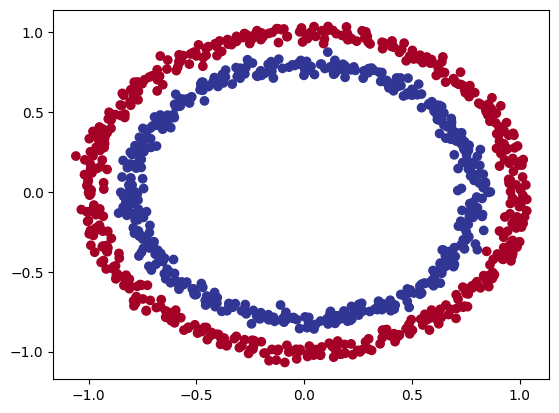

In [64]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### Check input and output shapes

In [65]:
X.shape, y.shape

((1000, 2), (1000,))

### Turn data into tensors and create train-test splits

In [66]:
import torch
torch.__version__

'2.0.1+cu118'

In [67]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [68]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [69]:
# Split data into train-test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  # 20% of data will be test
                                                    random_state=42)

In [70]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a model

Goals:

1. Setup a device agnostic code so that our code will run on GPU if there is one
2. Construct a model (by subclassing ```nn.Module```)
3. Define a loss function and optimizer
4. Create a training and test loop


In [71]:
from torch import nn

# Make device agnostic code
device = 'cude' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [72]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### Constructing a Model

Let's create a model that:

1. Subclasses `nn.Module`
2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [73]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()

        # Create 2 nn.Linear() that can handle the shapes of our data

        # First layer takes in 2 features and upscales it to 5 features at the output
        self.layer_1 = nn.Linear(in_features=2,     # number of input features
                                 out_features=5)    # number of output features

        # Takes in 5 features from the previous layer and returns a final output of one feature (ie. 1-d vector) same shape as y
        self.layer_2 = nn.Linear(in_features=5,     # should match with the output features of the previous layer
                                 out_features=1)    # our final output

        # Defines a forward() that outlines the forward pass (or forward computation) of the model
        def forward(self, x):
            return self.layer_2(self.layer_1(x))    # x -> layer_1 -> layer_2 -> output


# Instantiate an instance of our model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [74]:
device

'cpu'

In [75]:
next(model_0.parameters()).device   # model_0.parameters() returns a generator

device(type='cpu')

In [76]:
help(next)

Help on built-in function next in module builtins:

next(...)
    next(iterator[, default])
    
    Return the next item from the iterator. If default is given and the iterator
    is exhausted, it is returned instead of raising StopIteration.



### Neural Network Playground

Link: https://playground.tensorflow.org/

In [77]:
## Let's replicate the above model using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [78]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3948, -0.1807],
                      [-0.4035, -0.2421],
                      [-0.5283,  0.2522],
                      [ 0.5473, -0.6657],
                      [ 0.1642,  0.3653]])),
             ('0.bias', tensor([ 0.1282, -0.2518,  0.3691,  0.3716,  0.2644])),
             ('1.weight',
              tensor([[-0.0786, -0.1184,  0.0478, -0.0790, -0.1333]])),
             ('1.bias', tensor([0.2859]))])

In [79]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

In [80]:
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [81]:
untrained_preds[:10]

tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853],
        [0.1785],
        [0.2280],
        [0.1960],
        [0.2965],
        [0.3120]])

In [82]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### Setup a Loss Function and Optimizer

Loss Function measures how **wrong** your model predictions are

Choosing a loss function or optimizer is problem specific

- For Regression you might want to use MAE or MSE
- For Classification you might want binary cross entropy or categorical cross entropy

For optimizers, two of the most common and useful are SGD and Adam

Info on Binary Cross Entropy: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

For some common Loss Functions and Optimizers, check: https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

In [83]:
# Setup the loss function

loss_fn = nn.BCEWithLogitsLoss()
# BCELoss with Sigmoid activation function
# Can also be written as nn.Sequential(nn.Sigmoid(), nn.BCELoss()), but the above is more numerically stable (see docs)

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [84]:
# Calculate accuracy: TP / (TP + TN) * 100

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Train Model

To train our model, we're going to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. Loss Backward (backpropagation)
5. Optimizer step (gradient descent)

### Going from Raw logits -> Prediction Probabilities -> Prediction Labels

- Our model outputs are going to be **raw logits**

- We can convert logits into prediction probabilities by using some **activation function** (Eg. Sigmoid for binary classification or Softmax for multiclass classification)

- Then we can convert these prediction probabilities to prediction labels by rounding them ortaking the `argmax`

In [85]:
# View the first 5 outputs of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853]])

In [86]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [87]:
# Use sigmoid activation function on our model logits, to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5809],
        [0.5779],
        [0.5725],
        [0.5834],
        [0.5462]])

In [88]:
# Use torch.round to get labels (ie. we consider 0.5 as our decision boundary)
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [89]:
# One-liner:

model_0.eval()
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

### Building a training and testing loop

In [90]:
# Set seed to get deterministic results

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):

    # Training
    model_0.train()

    # Forward pass
    # Turn logits -> pred probs -> pred labels
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss / accuracy
    # Our loss function: BCEWithLogitsLoss, expects logits as input
    # If it was BCELoss, it would expect pred probs (ie. torch.sigmoid(y_logits)) as input
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss / acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss: .5f} | Accuracy: {acc: .2f} | \
                Test Loss: {test_loss: .5f} | Test Accuracy: {test_acc: .2f}')

Epoch: 0 | Loss:  0.70175 | Accuracy:  50.00 |                 Test Loss:  0.70198 | Test Accuracy:  50.00
Epoch: 10 | Loss:  0.69749 | Accuracy:  50.00 |                 Test Loss:  0.69785 | Test Accuracy:  50.00
Epoch: 20 | Loss:  0.69541 | Accuracy:  50.00 |                 Test Loss:  0.69580 | Test Accuracy:  50.00
Epoch: 30 | Loss:  0.69438 | Accuracy:  50.50 |                 Test Loss:  0.69477 | Test Accuracy:  50.50
Epoch: 40 | Loss:  0.69385 | Accuracy:  57.38 |                 Test Loss:  0.69425 | Test Accuracy:  54.50
Epoch: 50 | Loss:  0.69357 | Accuracy:  53.00 |                 Test Loss:  0.69397 | Test Accuracy:  53.00
Epoch: 60 | Loss:  0.69341 | Accuracy:  52.12 |                 Test Loss:  0.69383 | Test Accuracy:  54.00
Epoch: 70 | Loss:  0.69331 | Accuracy:  51.38 |                 Test Loss:  0.69375 | Test Accuracy:  51.50
Epoch: 80 | Loss:  0.69325 | Accuracy:  51.38 |                 Test Loss:  0.69371 | Test Accuracy:  52.00
Epoch: 90 | Loss:  0.69320 | 

### Make predictions and Evaluate the model

From the metrics, looks like the model isn't learning anything

In [91]:
## Download helper functions

import requests
from pathlib import Path
if not Path('helper_functions.py').is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [92]:
from helper_functions import plot_predictions, plot_decision_boundary

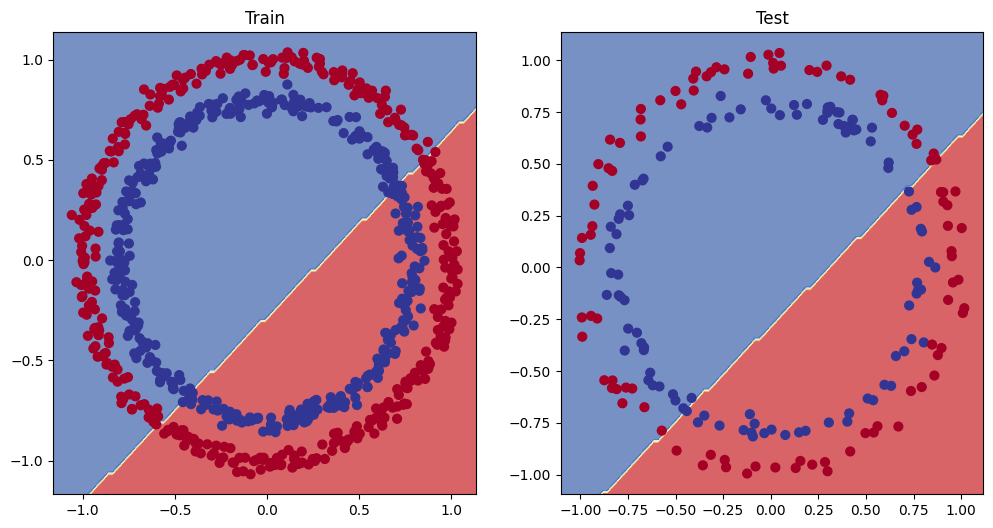

In [93]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving our model

- Add more layers - give the model more chances to learn about patterns in data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Change the activation functions
- Change the learning rate
- Change the loss function

Since these are values that we can change, they are referred to as **Hyperparameters**

In [94]:
# Improving our model by -
    # Adding more hidden units: 5 -> 10
    # Adding more layers: 2 -> 3
    # Increasing number of epochs: 100 -> 1000

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))  # This way of writing operations leverages speedups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [95]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3882, -0.1814],
                      [-0.4123, -0.2431],
                      [-0.5299,  0.2518],
                      [ 0.5385, -0.6666],
                      [ 0.1508,  0.3639]])),
             ('0.bias', tensor([ 0.1427, -0.2327,  0.3685,  0.3894,  0.2918])),
             ('1.weight',
              tensor([[-0.0716, -0.1113, -0.0600, -0.1072, -0.1665]])),
             ('1.bias', tensor([0.1069]))])

In [96]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [97]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [98]:
# Write training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # Training
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and accuracy
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        y_test_logits = model_1(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        # Calculate loss and accuracy
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss: .5f} | Accuracy: {acc: .2f} | \
                Test Loss: {test_loss: .5f} | Test Accuracy: {test_acc: .2f}')

Epoch: 0 | Loss:  0.69396 | Accuracy:  50.88 |                 Test Loss:  0.69261 | Test Accuracy:  51.00
Epoch: 100 | Loss:  0.69305 | Accuracy:  50.38 |                 Test Loss:  0.69379 | Test Accuracy:  48.00
Epoch: 200 | Loss:  0.69299 | Accuracy:  51.12 |                 Test Loss:  0.69437 | Test Accuracy:  46.00
Epoch: 300 | Loss:  0.69298 | Accuracy:  51.62 |                 Test Loss:  0.69458 | Test Accuracy:  45.00
Epoch: 400 | Loss:  0.69298 | Accuracy:  51.12 |                 Test Loss:  0.69465 | Test Accuracy:  46.00
Epoch: 500 | Loss:  0.69298 | Accuracy:  51.00 |                 Test Loss:  0.69467 | Test Accuracy:  46.00
Epoch: 600 | Loss:  0.69298 | Accuracy:  51.00 |                 Test Loss:  0.69468 | Test Accuracy:  46.00
Epoch: 700 | Loss:  0.69298 | Accuracy:  51.00 |                 Test Loss:  0.69468 | Test Accuracy:  46.00
Epoch: 800 | Loss:  0.69298 | Accuracy:  51.00 |                 Test Loss:  0.69468 | Test Accuracy:  46.00
Epoch: 900 | Loss:  0

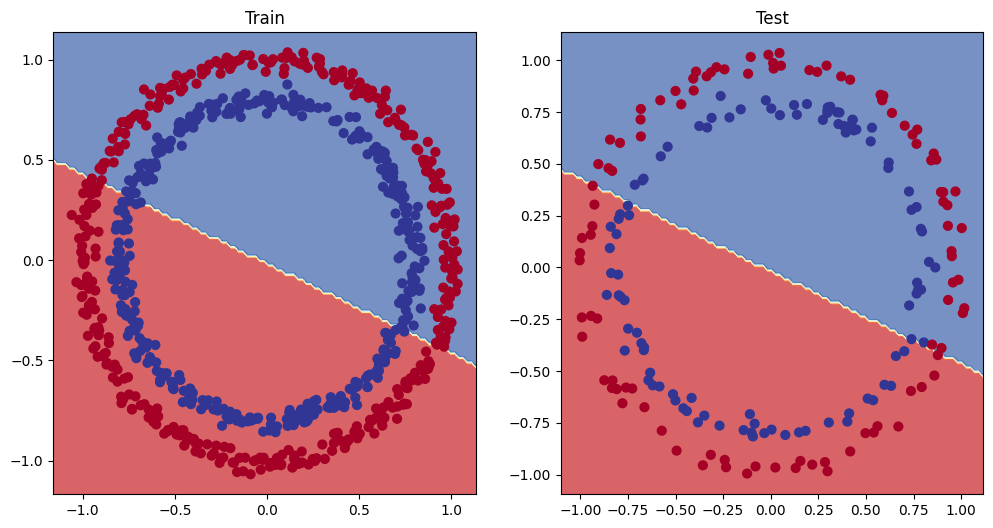

In [99]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [100]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias     # Linear Regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [101]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [102]:
len(X_train_regression), len(X_test_regression)

(80, 20)

In [103]:
len(y_train_regression), len(y_test_regression)

(80, 20)

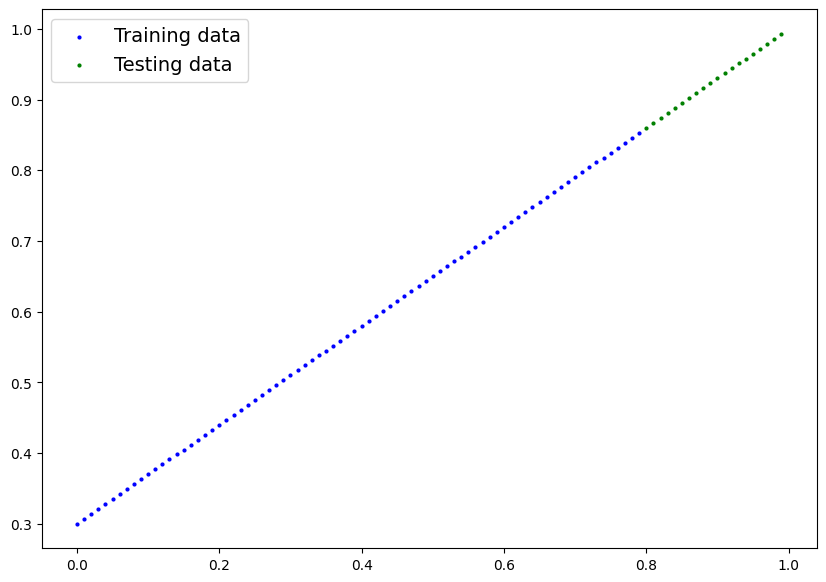

In [104]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### Adjusting model_1 to fit a straight line

In [105]:
# Same architecture as model_1 (but using nn.Sequential())

reg_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

reg_model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [106]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=reg_model.parameters(), lr=0.01)

In [107]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

    # Forward pass
    y_pred = reg_model(X_train_regression)

    # Calculate loss
    loss = loss_fn(y_pred,
                   y_train_regression)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    reg_model.eval()
    with torch.inference_mode():
        # Forward pass
        y_test_pred = reg_model(X_test_regression)

        # Calculate loss
        test_loss = loss_fn(y_test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss: .5f} | Test Loss: {test_loss: .5f}')



Epoch: 0 | Loss:  0.75986 | Test Loss:  0.91103
Epoch: 100 | Loss:  0.02858 | Test Loss:  0.00081
Epoch: 200 | Loss:  0.02533 | Test Loss:  0.00209
Epoch: 300 | Loss:  0.02137 | Test Loss:  0.00305
Epoch: 400 | Loss:  0.01964 | Test Loss:  0.00341
Epoch: 500 | Loss:  0.01940 | Test Loss:  0.00387
Epoch: 600 | Loss:  0.01903 | Test Loss:  0.00379
Epoch: 700 | Loss:  0.01878 | Test Loss:  0.00381
Epoch: 800 | Loss:  0.01840 | Test Loss:  0.00329
Epoch: 900 | Loss:  0.01798 | Test Loss:  0.00360


In [108]:
# Evaluate model
reg_model.eval

with torch.inference_mode():
    y_preds = reg_model(X_test_regression)

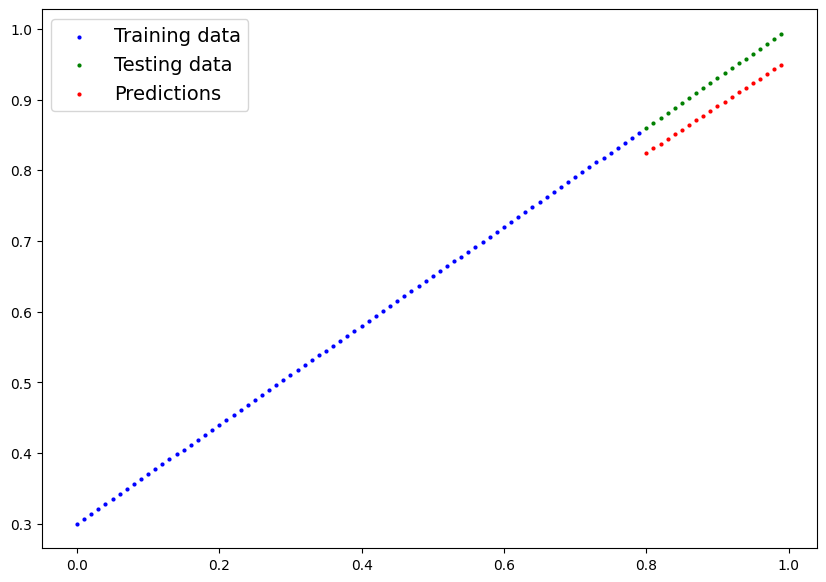

In [109]:
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_test_pred.cpu());

### Introducing Non-Linearity

### Recreating non-linear data (red and blue circles)

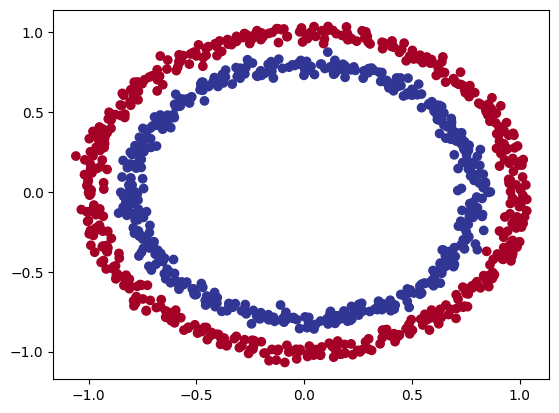

In [110]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [111]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [116]:
X_train[:5], y_train[:5], X_test[:5], y_test[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([1., 0., 1., 0., 1.]))

### Building a model with non-linearity

In [135]:
# Building a model with non-linear activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # Using ReLU non-linear activation
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

# NOTE: We apply the sigmoid non-linear activation function to the logits of our model after layer_3

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [137]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.03)

In [138]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10001

for epoch in range(epochs):
    model_2.train()

    # Get logit
    y_logit = model_2(X_train).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logit))

    # Get forward loss and accuracy
    loss = loss_fn(y_logit, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_labels)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward Loss (Backpropation)
    loss.backward()

    # Optimizer step (Gradient Descent)
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        y_test_logit = model_2(X_test).squeeze()
        y_test_labels = torch.round(torch.sigmoid(y_test_logit))

        # Forward Loss and Accuracy
        test_loss = loss_fn(y_test_logit, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)

    # Print Loss and Accuracy
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc: .2f} | Test Loss: {test_loss: .5f} | Test Acc: {test_acc: .2f}')




Epoch: 0 | Loss:  0.69833 | Acc:  50.00 | Test Loss:  0.69873 | Test Acc:  49.50
Epoch: 1000 | Loss:  0.68762 | Acc:  56.62 | Test Loss:  0.68831 | Test Acc:  55.00
Epoch: 2000 | Loss:  0.67277 | Acc:  56.00 | Test Loss:  0.67178 | Test Acc:  60.50
Epoch: 3000 | Loss:  0.62157 | Acc:  81.88 | Test Loss:  0.63239 | Test Acc:  78.00
Epoch: 4000 | Loss:  0.44688 | Acc:  95.75 | Test Loss:  0.48196 | Test Acc:  94.50
Epoch: 5000 | Loss:  0.18179 | Acc:  99.38 | Test Loss:  0.23934 | Test Acc:  97.50
Epoch: 6000 | Loss:  0.07989 | Acc:  99.62 | Test Loss:  0.13104 | Test Acc:  98.00
Epoch: 7000 | Loss:  0.04594 | Acc:  100.00 | Test Loss:  0.09070 | Test Acc:  99.00
Epoch: 8000 | Loss:  0.03192 | Acc:  100.00 | Test Loss:  0.07256 | Test Acc:  99.00
Epoch: 9000 | Loss:  0.02463 | Acc:  100.00 | Test Loss:  0.06223 | Test Acc:  99.00
Epoch: 10000 | Loss:  0.02016 | Acc:  100.00 | Test Loss:  0.05569 | Test Acc:  99.00


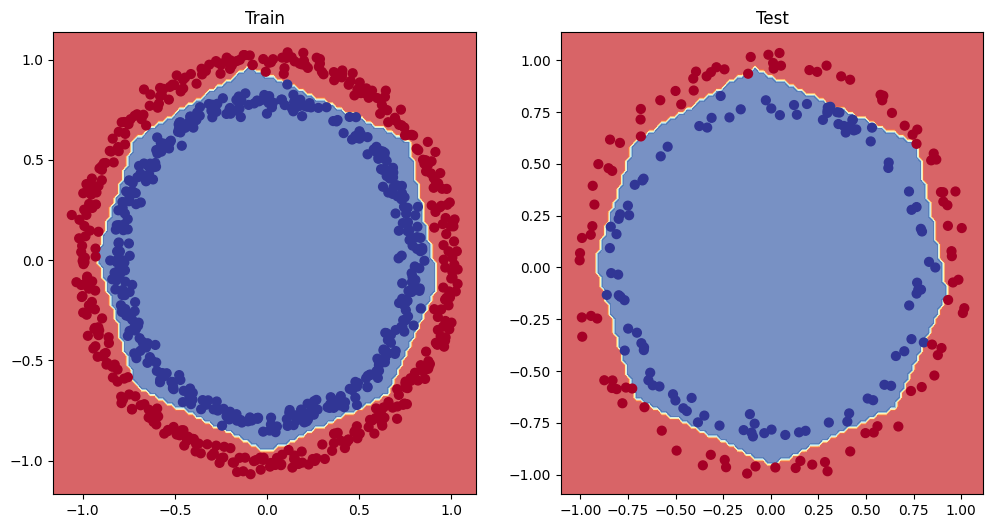

In [139]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### Building a Multi-Class (ie. more than 2 classes) classification problem

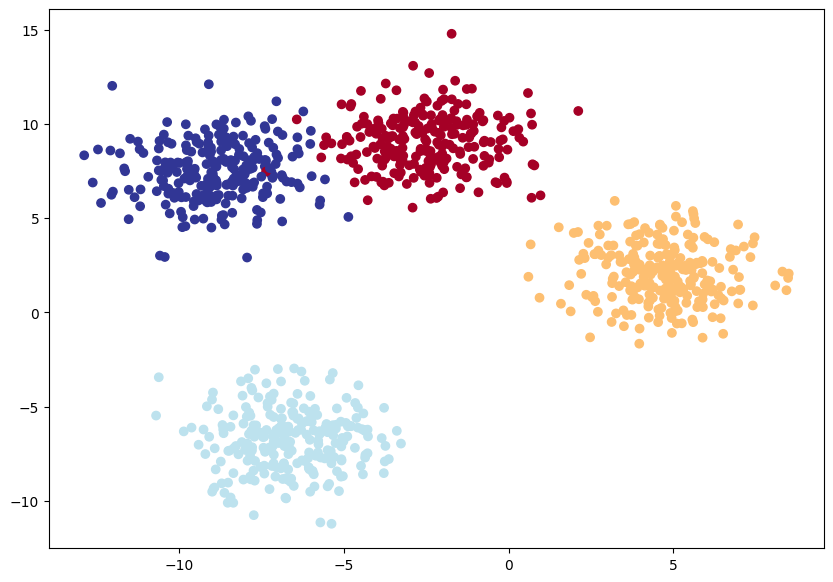

In [140]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparamters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### Build a multi-class classification model

In [141]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [154]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=2,
                    output_features=4,  # equals the number of classes in y
                    hidden_units=8).to(device)

model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [155]:
# Create loss function and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_3.parameters(), lr=0.03)

Softmax(x_i) = exp(x_i) / sum(exp(x_j) for all j)




In [163]:
# Train Model
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 101

# Put data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # using argmax instead of torch.round for multiclass

    # Calculate forward loss and accuracy
    loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
    acc = accuracy_fn(y_blob_train, y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward loss (Backpropagation)
    loss.backward()

    # Optimizer step (Gradient Descent)
    optimizer.step()

    ### TESTING
    model_3.eval()
    with torch.inference_mode():
        y_test_logits = model_3(X_blob_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_test_logits, y_blob_test.type(torch.LongTensor))
        test_acc = accuracy_fn(y_blob_test, y_test_pred)

    # Print Loss and Accuracy
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc: .2f} | Test Loss: {test_loss: .5f} | Test Acc: {test_acc: .2f}')






Epoch: 0 | Loss:  0.02503 | Acc:  99.25 | Test Loss:  0.01441 | Test Acc:  99.50
Epoch: 10 | Loss:  0.02500 | Acc:  99.25 | Test Loss:  0.01436 | Test Acc:  99.50
Epoch: 20 | Loss:  0.02497 | Acc:  99.25 | Test Loss:  0.01433 | Test Acc:  99.50
Epoch: 30 | Loss:  0.02494 | Acc:  99.25 | Test Loss:  0.01428 | Test Acc:  99.50
Epoch: 40 | Loss:  0.02492 | Acc:  99.25 | Test Loss:  0.01425 | Test Acc:  99.50
Epoch: 50 | Loss:  0.02489 | Acc:  99.25 | Test Loss:  0.01421 | Test Acc:  99.50
Epoch: 60 | Loss:  0.02486 | Acc:  99.25 | Test Loss:  0.01417 | Test Acc:  99.50
Epoch: 70 | Loss:  0.02484 | Acc:  99.25 | Test Loss:  0.01413 | Test Acc:  99.50
Epoch: 80 | Loss:  0.02481 | Acc:  99.25 | Test Loss:  0.01409 | Test Acc:  99.50
Epoch: 90 | Loss:  0.02479 | Acc:  99.25 | Test Loss:  0.01406 | Test Acc:  99.50
Epoch: 100 | Loss:  0.02476 | Acc:  99.25 | Test Loss:  0.01402 | Test Acc:  99.50


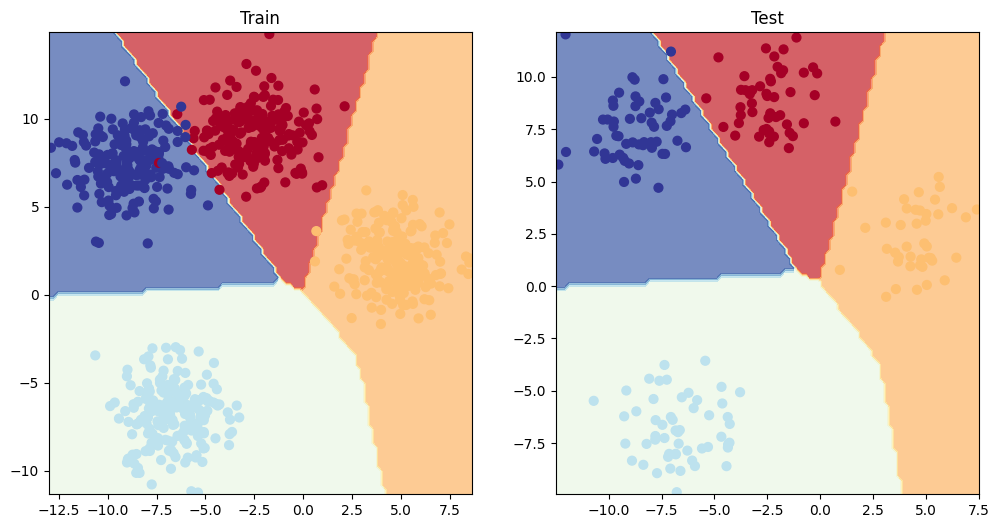

In [165]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

#### Try training the model using on linear activation function in hidden layers

### Additional Classification metrics:

- Accuracy
- Precision
- Recall
- F-beta score (Eg. F-1 score)
- Confusion matrix
- Classification report